# Supervised Learning

This notebook contains the supervised learning component of the Pokemon battle predictor project.

## Imports

All necessary imports.

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [5]:
# Random seed constant
RANDOM_SEED = 42

## Preprocessing

Here, we load and preprocess our datafile.

In [9]:
df = pd.read_csv("battle_data_w_stat_features_and_cls_labels.csv")

In [11]:
def preprocess_data(df, rating_filt=None, use_leads=False):

  not_used = ["disconnect", "forfeit", "turn_count", "p1_player", "p2_player"]

  if not use_leads:
    not_used += ["p1_lead_1", "p1_lead_2", "p2_lead_1", "p2_lead_2"]

  if rating_filt:
    df = df.drop(not_used, axis=1)
    df = df.dropna()
    df = df[df["rating"] >= rating_filt]
    df = df.drop("rating", axis=1)
  else:
    not_used.append("rating")
    df = df.drop(not_used, axis=1)
    df = df.dropna()

  return df

In [13]:
# Creating 4 versions of our DataFrame to use for modeling

df_all = preprocess_data(df) # All data
df_all_w_leads = preprocess_data(df, use_leads=True) # All data (with leads included)
df_high_rank = preprocess_data(df, rating_filt=1200) # Only battles of rank 1200 or higher
df_high_rank_w_leads = preprocess_data(df, rating_filt=1200, use_leads=True) # Only battles of rank 1200 or higher (with leads included)

## Logistic Regression

Here, we train and test a logistic regression model on our data. For each run, we also grid search to find the best parameter value for c, and the best choice between L1 and L2 regularization.

In [16]:
def fit_lr_model(df, grid_search=True):
    X = df.loc[:, df.columns != "p1_win"]
    y = df["p1_win"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    categorical_cols = X_train.columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols)
        ]
    )

    # Default parameters
    pipe = Pipeline([
        ("pre", preprocessor),
        ("logreg", LogisticRegression(
            max_iter=200,
            solver="saga",
            n_jobs=-1,
            class_weight="balanced"
        ))
    ])

    if grid_search:
        print("Starting grid search (this may take a while)...")
        param_grid = {
            "logreg__C": [0.01, 0.1, 1, 5, 10],
            "logreg__penalty": ["l1", "l2"]
        }
        grid = GridSearchCV(pipe, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
        grid.fit(X_train, y_train)
        print("Best params:", grid.best_params_)
        print("Best CV score:", grid.best_score_)
        best_clf = grid.best_estimator_
    else:
        print("Fitting with default parameters (C=1.0, penalty='l2')...")
        # Set default parameters explicitly for clarity
        pipe.set_params(logreg__C=1.0, logreg__penalty="l2")
        best_clf = pipe.fit(X_train, y_train)

    print("Evaluating on test set...")
    y_pred = best_clf.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_clf

In [18]:
lr_model_all_data = fit_lr_model(df_all)

Starting grid search (this may take a while)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Best CV score: 0.5271441605839416
Evaluating on test set...
Test Accuracy: 0.5302523563393129
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      1669
           1       0.52      0.54      0.53      1620

    accuracy                           0.53      3289
   macro avg       0.53      0.53      0.53      3289
weighted avg       0.53      0.53      0.53      3289



In [19]:
lr_model_all_data_w_leads = fit_lr_model(df_all_w_leads)

Starting grid search (this may take a while)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Best CV score: 0.5367192862045298
Evaluating on test set...
Test Accuracy: 0.5300396462336078
              precision    recall  f1-score   support

           0       0.53      0.54      0.54      1646
           1       0.53      0.52      0.52      1633

    accuracy                           0.53      3279
   macro avg       0.53      0.53      0.53      3279
weighted avg       0.53      0.53      0.53      3279



In [20]:
lr_model_high_rank = fit_lr_model(df_high_rank)

Starting grid search (this may take a while)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'logreg__C': 0.01, 'logreg__penalty': 'l2'}
Best CV score: 0.5315975047464062
Evaluating on test set...
Test Accuracy: 0.4761388286334056
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       471
           1       0.47      0.48      0.47       451

    accuracy                           0.48       922
   macro avg       0.48      0.48      0.48       922
weighted avg       0.48      0.48      0.48       922



In [21]:
lr_model_high_rank_w_leads = fit_lr_model(df_high_rank_w_leads)

Starting grid search (this may take a while)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Best CV score: 0.5171493041661108
Evaluating on test set...
Test Accuracy: 0.5048966267682263
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       470
           1       0.49      0.52      0.50       449

    accuracy                           0.50       919
   macro avg       0.51      0.51      0.50       919
weighted avg       0.51      0.50      0.50       919



## Random Forest Model

Here we train and test our predictor using a random forest regressor.

In [23]:
def fit_rf_model(df):
    X = df.loc[:, df.columns != "p1_win"]
    y = df["p1_win"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    categorical_cols = X_train.columns.tolist()
    preprocessor = ColumnTransformer([
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
    ])

    pipe = Pipeline([
        ("pre", preprocessor),
        ("rf", RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced"
        ))
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return pipe

In [24]:
fit_rf_model(df_all)

Random Forest Accuracy: 0.5259957433870477
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      1669
           1       0.52      0.53      0.52      1620

    accuracy                           0.53      3289
   macro avg       0.53      0.53      0.53      3289
weighted avg       0.53      0.53      0.53      3289



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['p1_species_1', 'p1_item_1',
                                                   'p1_ability_1',
                                                   'p1_move_1_1', 'p1_move_1_2',
                                                   'p1_move_1_3', 'p1_move_1_4',
                                                   'p1_species_2', 'p1_item_2',
                                                   'p1_ability_2',
                                                   'p1_move_2_1', 'p1_move_2_2',
                                                   'p1_move_2_3', 'p1_move_2_4',
                                                   'p1_species_3', 'p1_item_3',
                                                   'p1_ability_3',
                                                   'p1_move_3_1', 'p1_move_3_2',
                                                   'p1_move_3_3', 'p1_move_3_4',
                                                   'p1_species_4', 'p1_item_4',
                                                   'p1_ability_4',
                                                   'p1_move_4_1', 'p1_move_4_2',
                                                   'p1_move_4_3', 'p1_move_4_4',
                                                   'p1_species_5', 'p1_item_5', ...])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [25]:
fit_rf_model(df_all_w_leads)

Random Forest Accuracy: 0.5147910948459896
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      1646
           1       0.51      0.52      0.52      1633

    accuracy                           0.51      3279
   macro avg       0.51      0.51      0.51      3279
weighted avg       0.51      0.51      0.51      3279



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['p1_species_1', 'p1_item_1',
                                                   'p1_ability_1',
                                                   'p1_move_1_1', 'p1_move_1_2',
                                                   'p1_move_1_3', 'p1_move_1_4',
                                                   'p1_species_2', 'p1_item_2',
                                                   'p1_ability_2',
                                                   'p1_move_2_1', 'p1_move_2_2',
                                                   'p1_move_2_3', 'p1_move_2_4',
                                                   'p1_species_3', 'p1_item_3',
                                                   'p1_ability_3',
                                                   'p1_move_3_1', 'p1_move_3_2',
                                                   'p1_move_3_3', 'p1_move_3_4',
                                                   'p1_species_4', 'p1_item_4',
                                                   'p1_ability_4',
                                                   'p1_move_4_1', 'p1_move_4_2',
                                                   'p1_move_4_3', 'p1_move_4_4',
                                                   'p1_species_5', 'p1_item_5', ...])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [26]:
fit_rf_model(df_high_rank)

Random Forest Accuracy: 0.5032537960954447
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       471
           1       0.49      0.50      0.49       451

    accuracy                           0.50       922
   macro avg       0.50      0.50      0.50       922
weighted avg       0.50      0.50      0.50       922



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['p1_species_1', 'p1_item_1',
                                                   'p1_ability_1',
                                                   'p1_move_1_1', 'p1_move_1_2',
                                                   'p1_move_1_3', 'p1_move_1_4',
                                                   'p1_species_2', 'p1_item_2',
                                                   'p1_ability_2',
                                                   'p1_move_2_1', 'p1_move_2_2',
                                                   'p1_move_2_3', 'p1_move_2_4',
                                                   'p1_species_3', 'p1_item_3',
                                                   'p1_ability_3',
                                                   'p1_move_3_1', 'p1_move_3_2',
                                                   'p1_move_3_3', 'p1_move_3_4',
                                                   'p1_species_4', 'p1_item_4',
                                                   'p1_ability_4',
                                                   'p1_move_4_1', 'p1_move_4_2',
                                                   'p1_move_4_3', 'p1_move_4_4',
                                                   'p1_species_5', 'p1_item_5', ...])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [27]:
fit_rf_model(df_high_rank_w_leads)

Random Forest Accuracy: 0.5266594124047879
              precision    recall  f1-score   support

           0       0.54      0.53      0.53       470
           1       0.52      0.53      0.52       449

    accuracy                           0.53       919
   macro avg       0.53      0.53      0.53       919
weighted avg       0.53      0.53      0.53       919



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['p1_species_1', 'p1_item_1',
                                                   'p1_ability_1',
                                                   'p1_move_1_1', 'p1_move_1_2',
                                                   'p1_move_1_3', 'p1_move_1_4',
                                                   'p1_species_2', 'p1_item_2',
                                                   'p1_ability_2',
                                                   'p1_move_2_1', 'p1_move_2_2',
                                                   'p1_move_2_3', 'p1_move_2_4',
                                                   'p1_species_3', 'p1_item_3',
                                                   'p1_ability_3',
                                                   'p1_move_3_1', 'p1_move_3_2',
                                                   'p1_move_3_3', 'p1_move_3_4',
                                                   'p1_species_4', 'p1_item_4',
                                                   'p1_ability_4',
                                                   'p1_move_4_1', 'p1_move_4_2',
                                                   'p1_move_4_3', 'p1_move_4_4',
                                                   'p1_species_5', 'p1_item_5', ...])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

## Trying with Just Engineered Features

Accuracy: 0.5104854926745188
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      1743
           1       0.51      0.51      0.51      1738

    accuracy                           0.51      3481
   macro avg       0.51      0.51      0.51      3481
weighted avg       0.51      0.51      0.51      3481



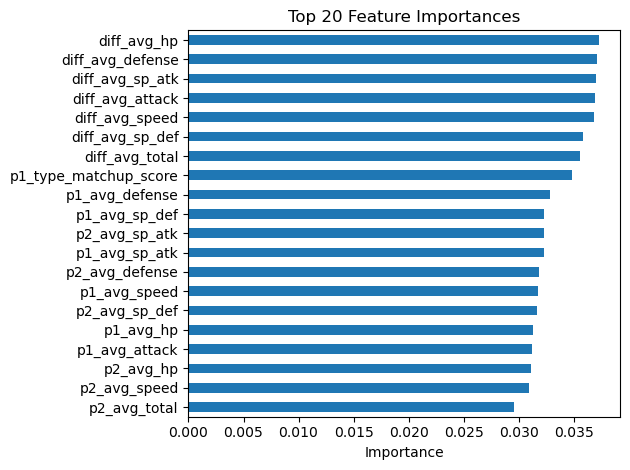

In [29]:
engineered_features = [
    'p1_num_fast_mons', 'p1_num_slow_mons', 'p2_num_fast_mons', 'p2_num_slow_mons',
    'p1_num_bulky_mons', 'p1_num_frail_mons', 'p2_num_bulky_mons', 'p2_num_frail_mons',
    'p1_num_high_power_mons', 'p1_num_low_power_mons', 'p2_num_high_power_mons', 'p2_num_low_power_mons',
    'p1_type_matchup_score',
    'p1_team_cluster', 'p2_team_cluster', 'cluster_pair',
    'p1_avg_total', 'p2_avg_total', 'diff_avg_total',
    'p1_avg_hp', 'p2_avg_hp', 'diff_avg_hp',
    'p1_avg_attack', 'p2_avg_attack', 'diff_avg_attack',
    'p1_avg_defense', 'p2_avg_defense', 'diff_avg_defense',
    'p1_avg_sp_atk', 'p2_avg_sp_atk', 'diff_avg_sp_atk',
    'p1_avg_sp_def', 'p2_avg_sp_def', 'diff_avg_sp_def',
    'p1_avg_speed', 'p2_avg_speed', 'diff_avg_speed',
    'p1_type_diversity', 'p2_type_diversity', 'diff_type_diversity',
    'p1_has_weather_setter_ability', 'p2_has_weather_setter_ability',
    'p1_has_weather_setter_move', 'p2_has_weather_setter_move',
    'p1_count_speed_control_move', 'p2_count_speed_control_move',
    'p1_has_priority_move', 'p2_has_priority_move',
    'p1_has_terrain_setter_ability', 'p2_has_terrain_setter_ability',
    'p1_has_terrain_setter_move', 'p2_has_terrain_setter_move',
    'p1_count_spread_move', 'p2_count_spread_move',
    'p1_has_hazard_setter_move', 'p2_has_hazard_setter_move',
    'p1_count_high_damage_move', 'p2_count_high_damage_move',
    'p1_has_recovery_move', 'p2_has_recovery_move',
    'p1_has_trick_room_move', 'p2_has_trick_room_move']

target = 'p1_win'

# one-hot encode categorical features ---
categorical = ['p1_team_cluster', 'p2_team_cluster', 'cluster_pair']
X = df[engineered_features].copy()

# one-hot encoding for clusters and cluster_pair
X = pd.get_dummies(X, columns=categorical, drop_first=True)

y = df[target]

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# fit random forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# plot feature importance
import matplotlib.pyplot as plt

importances = pd.Series(clf.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(20)
top_importances.plot(kind='barh')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()